# Using DQN and Double DQN in Pearl with different neural network instantiations.

Here is a [better rendering](https://nbviewer.org/github/facebookresearch/Pearl/blob/main/tutorials/sequential_decision_making/DQN_and_DoubleDQN_example.ipynb) of this notebook on [nbviewer](https://nbviewer.org/).

- The purpose of this tutorial is twofold. First, it illustrates how users can use implementations of value based methods, for example, DQN and Double DQN, in Pearl. We use a simple Gym environment for illustration.

- Second, it illustrates how users can instantiate a neural network (outside of a Pearl Agent) and pass it to different policy learners in Pearl. For both examples (DQN and Double DQN), we use an instantiation of `QValueNetworks` outside of the Pearl Agent. The default way right now is to instantiate a Q-value network inside the agent's policy learner.

- Users can also instantiate custom networks and use these with different policy learners in Pearl, but are expected to follow the general design of the value networks/critic networks/actor networks base class. For example, for value based methods such as DQN and Double DQN, users should follow the design of the `QValueNetwork` base class.

In [1]:
%load_ext autoreload
%autoreload 2

I0220 131306.287 magics.py:84] %autoreload was called with parameter_s='2'


# Pearl Installation

If you haven't installed Pearl, please make sure you install Pearl with the following cell. Otherwise, you can skip the cell below.



In [3]:
# Pearl installation from github. This install also includes PyTorch, Gym and Matplotlib

%pip uninstall Pearl -y
%rm -rf Pearl
!git clone https://github.com/facebookresearch/Pearl.git
%cd Pearl
%pip install .
%cd ..

Cloning into 'Pearl'...
remote: Enumerating objects: 5031, done.
remote: Counting objects: 100% (1243/1243), done.
remote: Compressing objects: 100% (328/328), done.
remote: Total 5031 (delta 1019), reused 1026 (delta 908), pack-reused 3788
Receiving objects: 100% (5031/5031), 13.55 MiB | 11.32 MiB/s, done.
Resolving deltas: 100% (3349/3349), done.
/content/Pearl
Processing /content/Pearl
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.8/211.8 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 20.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing met

# Import Modules

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from pearl.neural_networks.sequential_decision_making.q_value_networks import VanillaQValueNetwork
from pearl.utils.functional_utils.experimentation.set_seed import set_seed
from pearl.policy_learners.sequential_decision_making.deep_q_learning import DeepQLearning
from pearl.policy_learners.sequential_decision_making.double_dqn import DoubleDQN
from pearl.replay_buffers.sequential_decision_making.sarsa_replay_buffer import SARSAReplayBuffer
from pearl.utils.functional_utils.train_and_eval.online_learning import online_learning
from pearl.pearl_agent import PearlAgent
from pearl.utils.instantiations.environments.gym_environment import GymEnvironment
from pearl.action_representation_modules.one_hot_action_representation_module import (
    OneHotActionTensorRepresentationModule,
)

set_seed(0)

I0220 131543.347 gym_environment.py:27] Using 'gymnasium' package.


# Instantiate a simple Q value network

- In Pearl, Q-value networks assume inputs in the form of (state representation, action representation) and output estimated Q(s,a) through the `get_q_values` function.


In [3]:
env = GymEnvironment("CartPole-v1")
num_actions = env.action_space.n

# VanillaQValueNetwork class uses a simple mlp for approximating the Q values.
#  - Input dimension of the mlp = (state_dim + action_dim)
#  - Size of the intermediate layers are specified as list of `hidden_dims`.
hidden_dims = [64, 64]


# We will be using a one hot representation for representing actions. So take action_dim = num_actions.
Q_value_network = VanillaQValueNetwork(state_dim=env.observation_space.shape[0],  # dimension of the state representation
                                       action_dim=num_actions,                    # dimension of the action representation
                                       hidden_dims=hidden_dims,                   # dimensions of the intermediate layers
                                       output_dim=1)                              # set to 1 (Q values are scalars)

# Example 1: Set up a simple DQN agent

In [4]:
# Instead of using the 'network_type' argument, use the 'network_instance' argument.
# Pass Q_value_network as the `network_instance` to the `DeepQLearning` policy learner.
DQNagent = PearlAgent(
    policy_learner=DeepQLearning(
        state_dim=env.observation_space.shape[0],
        action_space=env.action_space,
        batch_size=64,
        training_rounds=10,
        soft_update_tau=0.75,
        network_instance=Q_value_network, # pass an instance of Q value network to the policy learner.
        action_representation_module=OneHotActionTensorRepresentationModule(
            max_number_actions=num_actions
        ),
    ),
    replay_buffer=SARSAReplayBuffer(10_000),
)

# Online interaction and learning

episode 20, step 189, agent=PearlAgent with DeepQLearning, FIFOOffPolicyReplayBuffer, env=CartPole-v1
return: 13.0
episode 40, step 397, agent=PearlAgent with DeepQLearning, FIFOOffPolicyReplayBuffer, env=CartPole-v1
return: 10.0
episode 60, step 2276, agent=PearlAgent with DeepQLearning, FIFOOffPolicyReplayBuffer, env=CartPole-v1
return: 47.0
episode 80, step 5935, agent=PearlAgent with DeepQLearning, FIFOOffPolicyReplayBuffer, env=CartPole-v1
return: 47.0
episode 100, step 9829, agent=PearlAgent with DeepQLearning, FIFOOffPolicyReplayBuffer, env=CartPole-v1
return: 154.0
episode 120, step 14433, agent=PearlAgent with DeepQLearning, FIFOOffPolicyReplayBuffer, env=CartPole-v1
return: 227.0
episode 140, step 23207, agent=PearlAgent with DeepQLearning, FIFOOffPolicyReplayBuffer, env=CartPole-v1
return: 395.0
episode 160, step 31856, agent=PearlAgent with DeepQLearning, FIFOOffPolicyReplayBuffer, env=CartPole-v1
return: 500.0
episode 180, step 39932, agent=PearlAgent with DeepQLearning, F

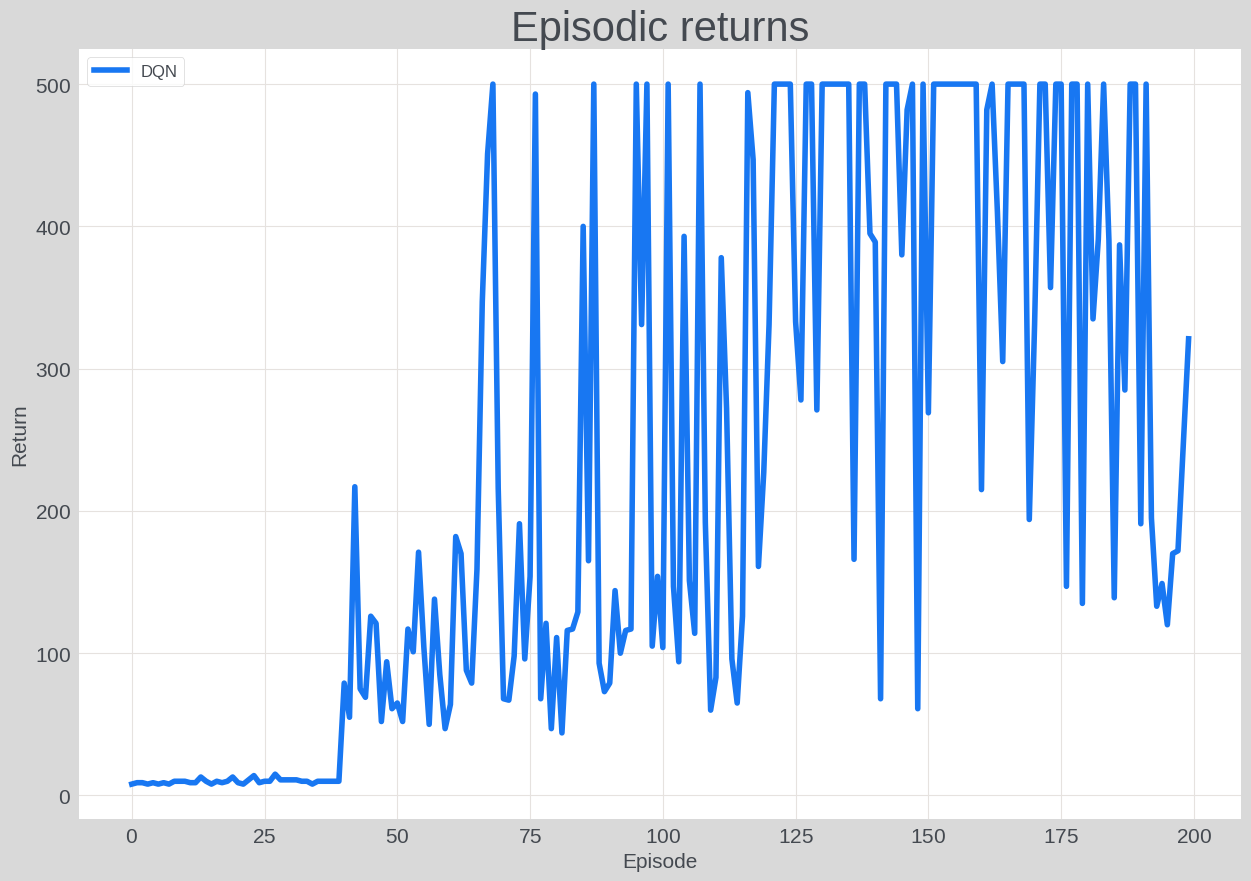

In [5]:
# The online learning function in Pearl implements environment interaction and learning
# and returns a dictionary with episodic returns

info = online_learning(
    agent=DQNagent,
    env=env,
    number_of_episodes=200,
    print_every_x_episodes=20,   # print returns after every 10 episdoes
    learn_after_episode=True,    # instead of updating after every environment interaction, Q networks are updates at the end of each episode
    seed=0
)

torch.save(info["return"], "DQN-return.pt")   # info["return"] refers to the episodic returns
plt.plot(np.arange(len(info["return"])), info["return"], label="DQN")
plt.title("Episodic returns")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.show()

# Example 2: Set up a simple Double DQN agent

In [6]:
# Set up a different instance of a Q value network.

# We will be using a one hot representation for representing actions. So take action_dim = num_actions.
Q_network_DoubleDQN = VanillaQValueNetwork(state_dim=env.observation_space.shape[0],  # dimension of the state representation
                                       action_dim=num_actions,                        # dimension of the action representation
                                       hidden_dims=hidden_dims,                       # dimensions of the intermediate layers
                                       output_dim=1)                                  # set to 1 (Q values are scalars)


In [7]:
# Instead of using the 'network_type' argument, use the 'network_instance' argument.
# Pass Q_value_network as the `network_instance` to the `DoubleDQN` policy learner.
DoubleDQNagent = PearlAgent(
    policy_learner=DoubleDQN(
        state_dim=env.observation_space.shape[0],
        action_space=env.action_space,
        batch_size=64,
        training_rounds=10,
        soft_update_tau=0.75,
        network_instance=Q_network_DoubleDQN,   # pass an instance of Q value network to the policy learner.
        action_representation_module=OneHotActionTensorRepresentationModule(
            max_number_actions=num_actions
        ),
    ),
    replay_buffer=SARSAReplayBuffer(10_000),
)

# Online interaction and learning

episode 20, step 209, agent=PearlAgent with DoubleDQN, FIFOOffPolicyReplayBuffer, env=CartPole-v1
return: 12.0
episode 40, step 810, agent=PearlAgent with DoubleDQN, FIFOOffPolicyReplayBuffer, env=CartPole-v1
return: 132.0
episode 60, step 2270, agent=PearlAgent with DoubleDQN, FIFOOffPolicyReplayBuffer, env=CartPole-v1
return: 89.0
episode 80, step 6281, agent=PearlAgent with DoubleDQN, FIFOOffPolicyReplayBuffer, env=CartPole-v1
return: 273.0
episode 100, step 14224, agent=PearlAgent with DoubleDQN, FIFOOffPolicyReplayBuffer, env=CartPole-v1
return: 431.0
episode 120, step 21746, agent=PearlAgent with DoubleDQN, FIFOOffPolicyReplayBuffer, env=CartPole-v1
return: 323.0
episode 140, step 29606, agent=PearlAgent with DoubleDQN, FIFOOffPolicyReplayBuffer, env=CartPole-v1
return: 500.0
episode 160, step 35901, agent=PearlAgent with DoubleDQN, FIFOOffPolicyReplayBuffer, env=CartPole-v1
return: 232.0
episode 180, step 41513, agent=PearlAgent with DoubleDQN, FIFOOffPolicyReplayBuffer, env=Car

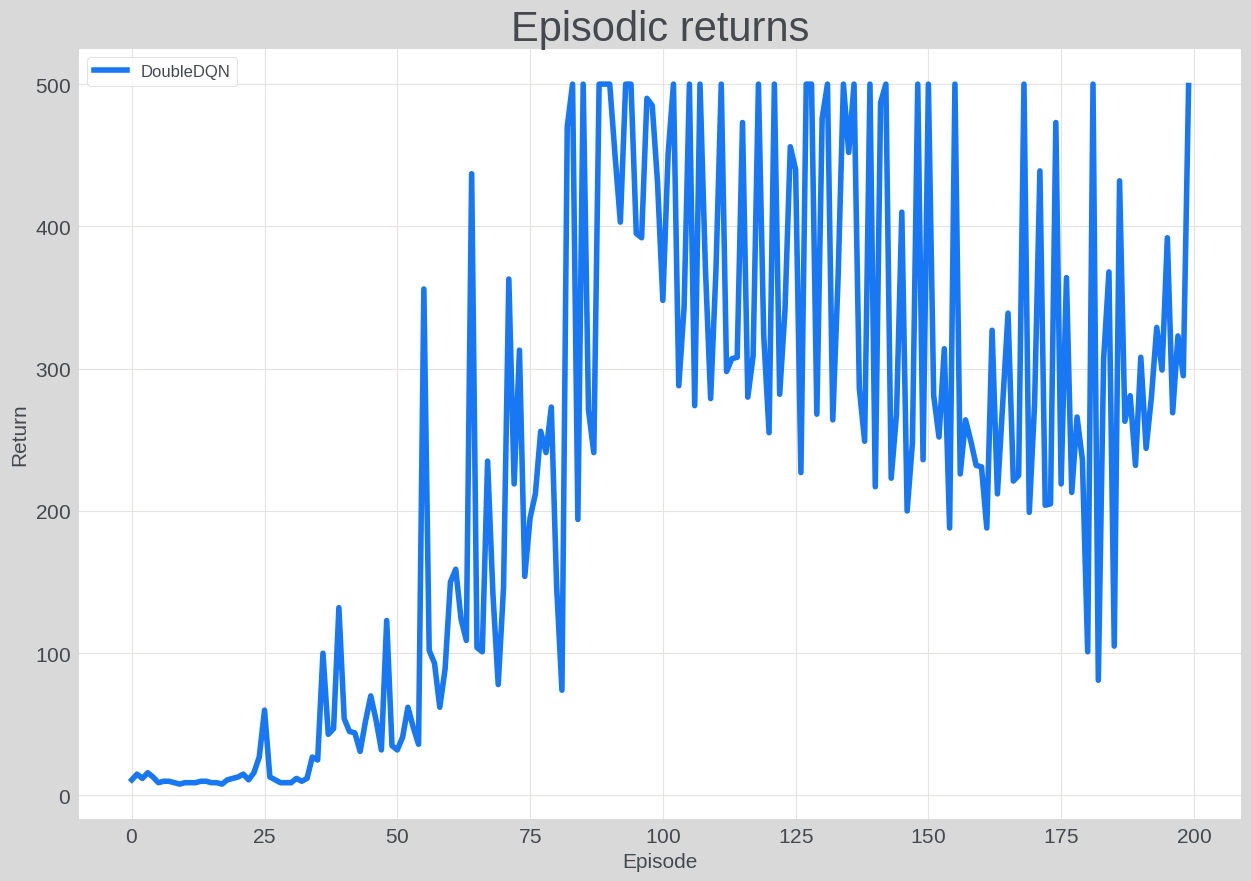

In [8]:
# The online learning function in Pearl implements environment interaction and learning
# and returns a dictionary with episodic returns

info_DoubleDQN = online_learning(
    agent=DoubleDQNagent,
    env=env,
    number_of_episodes=200,
    print_every_x_episodes=20,   # print returns after every 10 episdoes
    learn_after_episode=True,    # instead of updating after every environment interaction, Q networks are updates at the end of each episode
    seed=0
)

torch.save(info_DoubleDQN["return"], "DoubleDQN-return.pt")   # info["return"] refers to the episodic returns
plt.plot(np.arange(len(info_DoubleDQN["return"])), info_DoubleDQN["return"], label="DoubleDQN")
plt.title("Episodic returns")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.show()